# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd




In [2]:
# check
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data=pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [4]:
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


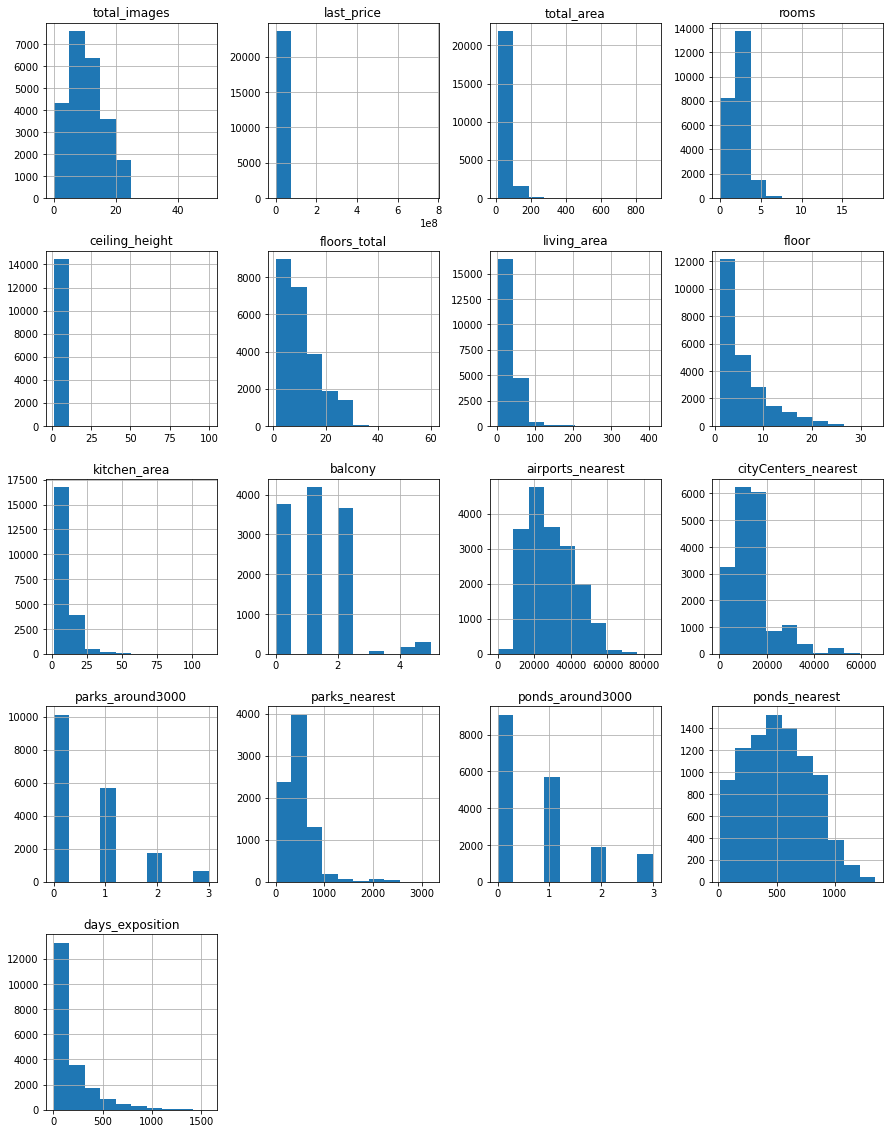

In [5]:
data.hist(figsize=(15, 20));

### Предобработка данных

In [6]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

ceiling_height - высота потолка чаще всего в домах стандартная +- 20 см, поэтому высоту потолка чаще всего указывают, если она не стандартная
floors_total - этих пропусков не так много, скорее всего ошибка при заполнении данных.
living_area - пропуски в жилой площади допущены скорее всего в квартирах студиях.
is_apartment - пропуски допущены, т.к. указаны данные только в тех случаях если недвижимость является аппартаментами
kitchen_area -лощадь кухни может быть не указана в квартирах студиях или в квартирах с объединенным залом и кухней
balcony - вместо балкона может быть указана лоджия
locality_name - этих пропусков не так много, скорее всего ошибка при заполнении данных.
airports_nearest, cityCenters_nearest, parks_around3000,parks_nearest, ponds_around3000, ponds_nearest - данные показатели дополнительные данные, которые показывают преимущество квартиры. Чаще всего заполнены данные, где этот показатель является преимуществом близостью расположения. 
days_exposition - пропуски в данном столбце могут показывать, что часть объявлений еще активны


In [7]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

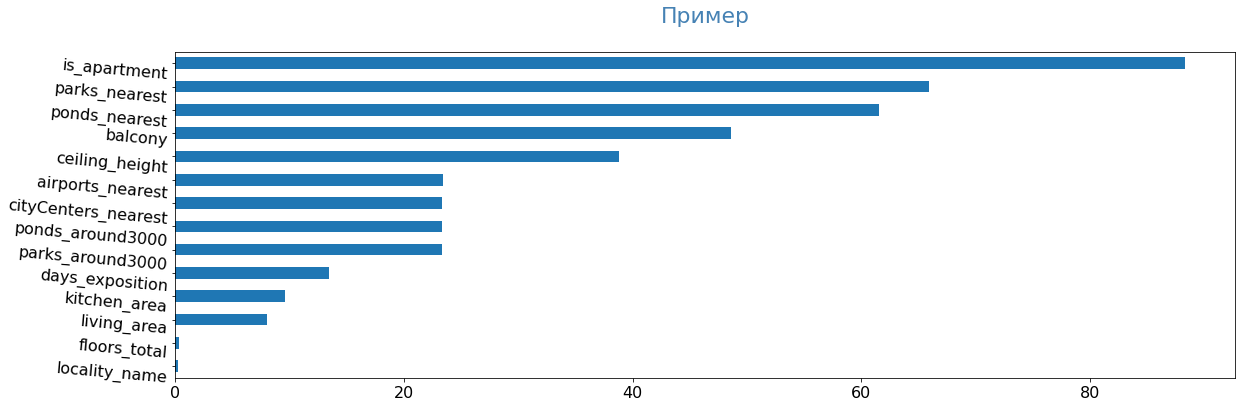

In [8]:
pass_value_barh(data)

In [9]:
data.dropna(subset=['locality_name','floors_total'])
data['ceiling_height']=data['ceiling_height'].fillna(data['ceiling_height'].median())
data.info()
data.isna().sum()
       

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [10]:
liv = data['living_area'].mean() / data['total_area'].mean()
kitch = data['kitchen_area'].mean() / data['total_area'].mean()
data['living_area'].fillna(liv * data['total_area'], inplace=True)
data['kitchen_area'].fillna(kitch * data['total_area'], inplace=True)
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area                 0
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area                0
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [11]:
data['total_area']*0.9 >= (data['living_area'] + data['kitchen_area'])

0        True
1        True
2        True
3        True
4        True
         ... 
23694    True
23695    True
23696    True
23697    True
23698    True
Length: 23699, dtype: bool

In [12]:
# check
data[data['total_area']*0.9 <= (data['living_area'] + data['kitchen_area'])][['living_area', 'kitchen_area', 'total_area']]

,living_area,kitchen_area,total_area
41,59.00,12.000000,74.0
171,38.00,10.000000,49.0
184,26.10,6.200000,30.2
220,28.00,9.000000,37.0
237,20.75,4.921594,28.1
...,...,...,...
23297,42.20,6.000000,48.2
23328,40.00,10.000000,54.0
23521,44.00,15.300000,65.0
23579,18.00,4.343614,24.8


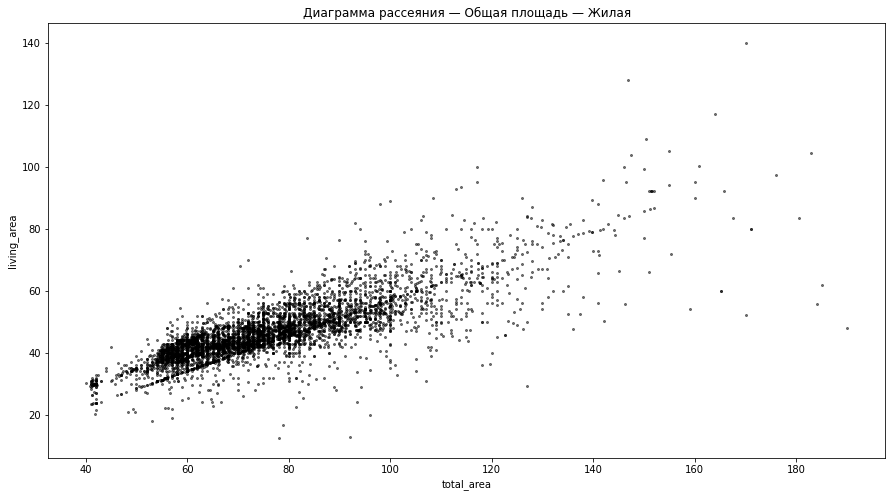

In [13]:
# check
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='living_area' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'black', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — Жилая');

In [14]:
data['kitchen_area'] = pd.to_numeric(data['kitchen_area'])
data['living_area'] = pd.to_numeric(data['living_area'])

После заполнения пропусков в столбцах, где производились замены тип данных был изменен на object.
Для дальнейшей работы необходимо из верныть в числовые значения.

In [15]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [16]:
data['locality_name']=data['locality_name'].str.replace("посёлок", "поселок") 
data['locality_name']=data['locality_name'].str.replace("городской поселок", "поселок городского типа")
data['locality_name'].unique()
duplicate=['поселок Мурино', 'деревня Кудрово']
name=['Мурино', 'Кудрово']
data['locality_name']=data['locality_name'].replace(duplicate, name)
data['locality_name'].unique()



array(['Санкт-Петербург', 'поселок Шушары',
       'поселок городского типа Янино-1', 'поселок Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'поселок городского типа Красный Бор',
       'Гатчина', 'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'поселок Металлострой',
       'поселок городского типа Лебяжье',
       'поселок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок городского типа Ефимовский', 'поселок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет', 'Сланцы

In [17]:
# check
data.locality_name.nunique()

321

In [18]:
data['ceiling_height'].unique()
data.drop(index=data.query('ceiling_height > 3.2 and ceiling_height < 25').index,inplace=True)
data.drop(index=data.query('ceiling_height < 2.3').index,inplace=True)
data.update(data[(data['ceiling_height'] >= 25) & (data['ceiling_height'] <= 36)]['ceiling_height']/10)
data.drop(index=data.query('ceiling_height > 36').index,inplace=True)
data['ceiling_height'].unique()

array([2.7 , 2.65, 3.03, 2.5 , 2.67, 2.56, 3.05, 2.75, 2.6 , 2.9 , 2.8 ,
       2.55, 3.  , 3.2 , 2.61, 2.77, 2.85, 2.64, 2.57, 2.71, 2.47, 2.73,
       2.84, 3.1 , 2.34, 3.06, 2.72, 2.54, 2.51, 2.78, 2.76, 2.58, 2.52,
       2.87, 2.66, 2.59, 2.45, 2.92, 3.11, 3.13, 3.15, 3.16, 3.12, 2.53,
       2.74, 2.96, 2.46, 2.79, 2.95, 2.94, 2.83, 2.4 , 3.01, 3.18, 2.3 ,
       2.48, 2.62, 2.82, 2.63, 2.88, 3.08, 3.07, 3.09, 2.81, 2.97, 3.14,
       2.68, 2.93, 2.98, 2.86, 3.17, 3.04, 3.02, 2.69, 2.99, 2.91, 2.89,
       2.49])

In [19]:
data.query('floors_total == 1')['floors_total'].count()

25

In [20]:
data.query('floors_total >30')['floors_total'].count()

31

In [21]:
data.drop(index=data.query('floors_total >30').index,inplace=True)

#### check area

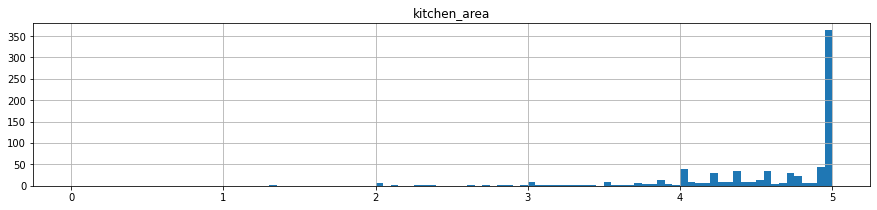

In [22]:
# check
data.hist(column = 'kitchen_area', bins = 100, figsize = (15,3), range = (0,5));

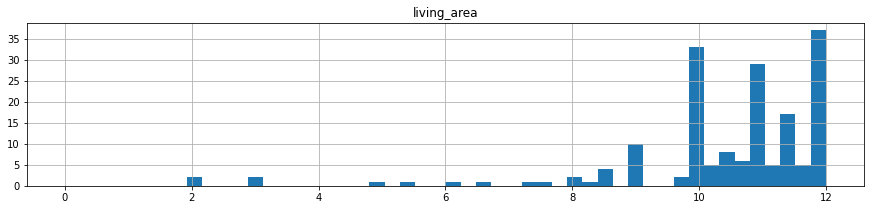

In [23]:
# check
data.hist(column = 'living_area', bins = 50, figsize = (15,3), range = (0,12));

In [24]:
data.query('living_area < 10')['living_area'].count()

29

In [25]:
data.query('living_area > 200')['living_area'].count()

23

In [26]:
data.drop(index=data.query('living_area < 10').index,inplace=True)
data.drop(index=data.query('living_area >200').index,inplace=True)

In [27]:
data.query('kitchen_area < 5')['kitchen_area'].count()

422

In [28]:
data.query('kitchen_area > 50')['kitchen_area'].count()

28

In [29]:
data.drop(index=data.query('kitchen_area < 5').index,inplace=True)
data.drop(index=data.query('kitchen_area >50').index,inplace=True)

In [30]:
data.query('days_exposition>365*3')['days_exposition'].count()

150

In [31]:
data.drop(index=data.query('days_exposition>365*3').index,inplace=True)
data.drop(index=data.query('days_exposition<3').index,inplace=True)

In [32]:
data.drop(index=data.query('rooms >7').index,inplace=True)

In [33]:
data.drop(index=data.query('last_price < 1000000').index,inplace=True)
data.drop(index=data.query('total_area >550000000').index,inplace=True)

#### check gap

In [34]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21969 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          21969 non-null  int64  
 1   last_price            21969 non-null  float64
 2   total_area            21969 non-null  float64
 3   first_day_exposition  21969 non-null  object 
 4   rooms                 21969 non-null  int64  
 5   ceiling_height        21969 non-null  float64
 6   floors_total          21895 non-null  float64
 7   living_area           21969 non-null  float64
 8   floor                 21969 non-null  int64  
 9   is_apartment          2571 non-null   object 
 10  studio                21969 non-null  bool   
 11  open_plan             21969 non-null  bool   
 12  kitchen_area          21969 non-null  float64
 13  balcony               11494 non-null  float64
 14  locality_name         21922 non-null  object 
 15  airports_nearest   

In [35]:
data['floors_total'].dropna(inplace= True)
data['is_apartment'].dropna(inplace=True)
data.info()
data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21969 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          21969 non-null  int64  
 1   last_price            21969 non-null  float64
 2   total_area            21969 non-null  float64
 3   first_day_exposition  21969 non-null  object 
 4   rooms                 21969 non-null  int64  
 5   ceiling_height        21969 non-null  float64
 6   floors_total          21895 non-null  float64
 7   living_area           21969 non-null  float64
 8   floor                 21969 non-null  int64  
 9   is_apartment          2571 non-null   object 
 10  studio                21969 non-null  bool   
 11  open_plan             21969 non-null  bool   
 12  kitchen_area          21969 non-null  float64
 13  balcony               11494 non-null  float64
 14  locality_name         21922 non-null  object 
 15  airports_nearest   

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               74
living_area                 0
floor                       0
is_apartment            19398
studio                      0
open_plan                   0
kitchen_area                0
balcony                 10475
locality_name              47
airports_nearest         5069
cityCenters_nearest      5050
parks_around3000         5049
parks_nearest           14639
ponds_around3000         5049
ponds_nearest           13697
days_exposition          2877
dtype: int64

In [36]:
try:
    data['last_price'] = data['last_price'].astype('int64')
    print('1ok')
except:
    print('last_price int type conversion fail')
    
try:
    data['floors_total'] =  data['floors_total'].astype('Int64')
    print('3ok')
except:
    print('floors_total int8 type conversion fail')
      
try:
    data['is_apartment'] = data['is_apartment'].map({'False':False, 'True':True})
    print('4ok')
except:
    print('is_apartment bool type conversion fail')
data.info()
        

1ok
3ok
4ok
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21969 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          21969 non-null  int64  
 1   last_price            21969 non-null  int64  
 2   total_area            21969 non-null  float64
 3   first_day_exposition  21969 non-null  object 
 4   rooms                 21969 non-null  int64  
 5   ceiling_height        21969 non-null  float64
 6   floors_total          21895 non-null  Int64  
 7   living_area           21969 non-null  float64
 8   floor                 21969 non-null  int64  
 9   is_apartment          0 non-null      object 
 10  studio                21969 non-null  bool   
 11  open_plan             21969 non-null  bool   
 12  kitchen_area          21969 non-null  float64
 13  balcony               11494 non-null  float64
 14  locality_name         21922 non-null  object 
 15  airport

In [37]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"21,969.00","21,969.00","21,969.00","19,092.00","21,969.00","21,969.00","21,969.00","21,969.00","21,895.00"
min,0.00,20.00,2.30,3.00,"1,000,000.00",10.00,5.00,1.00,1.00
max,7.00,413.50,3.20,"1,095.00","190,870,000.00",200.00,50.00,27.00,29.00


In [38]:
# check

try:
    df_check = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
# если не получилось прочитать файл из локальной папки, то загружаем данные из сети
except:
    df_check = pd.read_csv('real_estate_data.csv', sep='\t')

In [39]:
# check
df_check.rooms.value_counts().to_frame()

,rooms
1,8047
2,7940
3,5814
4,1180
5,326
0,197
6,105
7,59
8,12
9,8


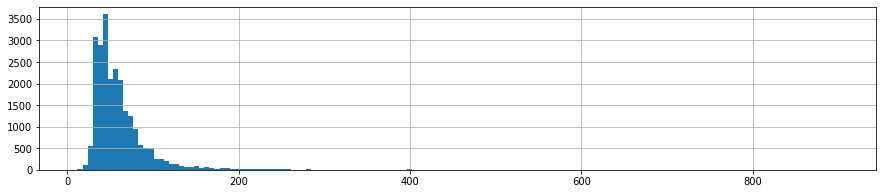

In [40]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3));

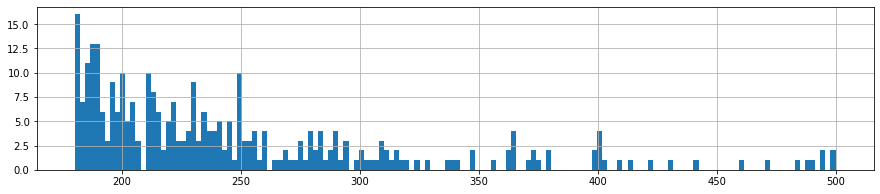

In [41]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

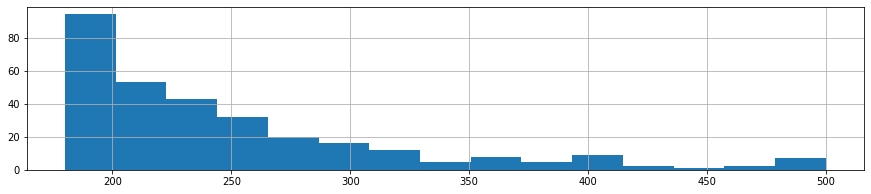

In [42]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (180,500));

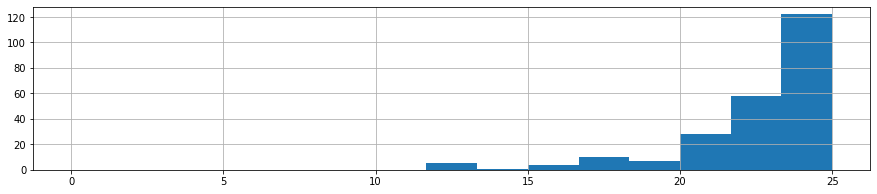

In [43]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (0,25));

In [44]:
data.drop(index=data.query('total_area < 20').index,inplace=True)
data.drop(index=data.query('total_area >250').index,inplace=True)

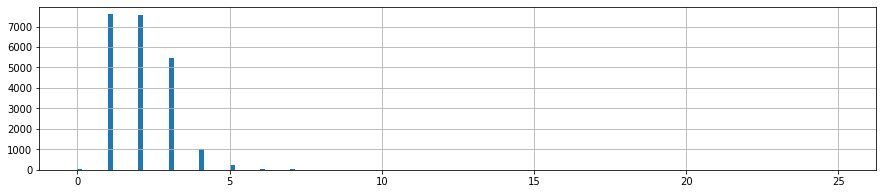

In [45]:
data['rooms'].sort_values(ascending=False).head(10)
data['rooms'].hist(bins = 150, figsize = (15,3), range = (0,25));

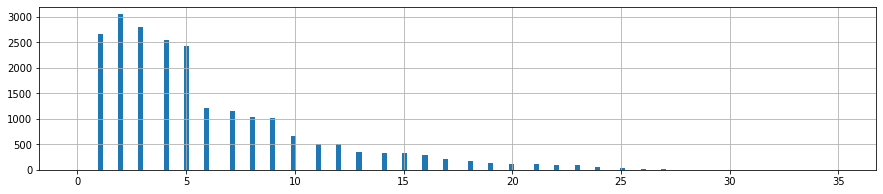

In [46]:
data['floor'].sort_values(ascending=False).head(10)
data['floor'].hist(bins = 150, figsize = (15,3), range = (0,35));

In [47]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.0012,0.00,25.00,2.42,3.00,"1,050,000.00",10.00,5.00,1.00,2.00
0.01,1.00,29.20,2.50,4.00,"1,300,000.00",13.50,5.00,1.00,2.00
0.5,2.00,51.70,2.65,93.00,"4,600,000.00",30.00,9.00,4.00,9.00
0.99,5.00,160.00,3.20,927.00,"26,990,000.00",94.89,30.28,23.00,26.00
0.9988,6.00,220.00,3.20,"1,078.13","64,074,153.60",140.00,44.00,26.00,27.00


In [48]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"21,934.00","21,934.00","21,934.00","19,062.00","21,934.00","21,934.00","21,934.00","21,934.00","21,861.00"
min,0.00,20.00,2.30,3.00,"1,000,000.00",10.00,5.00,1.00,1.00
max,7.00,250.00,3.20,"1,095.00","160,000,000.00",200.00,50.00,27.00,29.00


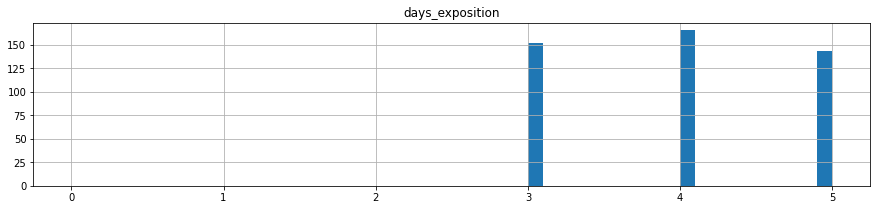

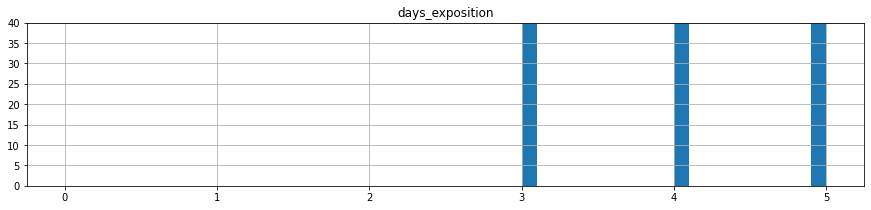

In [49]:
# check
data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5));

data.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0,5))
plt.ylim(0, 40);

### Посчитайте и добавьте в таблицу новые столбцы

In [50]:
data['price_sqr_m']=data['last_price']/data['total_area']

In [51]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S')
data['dayofweek']=data['first_day_exposition'].dt.dayofweek

In [52]:
data['month']=data['first_day_exposition'].dt.month

In [53]:
data['year']=data['first_day_exposition'].dt.year

In [54]:
data['floor_category'] = data.apply(
    lambda x: 'первый' if (x.floor == 1) 
    else ('последний' if (x.floor == x.floors_total) & isinstance(x.floors_total,int) 
    else 'другой'), axis=1
)

In [55]:
# check
data['floor_category'].value_counts()

другой       16274
последний     2991
первый        2669
Name: floor_category, dtype: int64

In [56]:
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest'] / 1000)
try:
    data['cityCenters_nearest_km'] =  data['cityCenters_nearest_km'].astype('Int32')
    print('cityCenters_nearest_km ok')
except:
    print('cityCenters_nearest_km')

cityCenters_nearest_km ok


In [57]:
data['cityCenters_nearest_km']

0          16
1          19
2          14
3           7
4           8
         ... 
23693      34
23695    <NA>
23696    <NA>
23697      10
23698    <NA>
Name: cityCenters_nearest_km, Length: 21934, dtype: Int32

In [58]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_sqr_m,dayofweek,month,year,floor_category,cityCenters_nearest_km
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,NaN,...,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой,16
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.600000,1,NaN,...,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый,19
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.300000,4,NaN,...,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой,14
3,0,64900000,159.0,2015-07-24,3,2.65,14,90.785766,9,NaN,...,84.0,3.0,234.0,424.0,408176.100629,4,7,2015,другой,7
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,NaN,...,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,другой,8


### Проведите исследовательский анализ данных

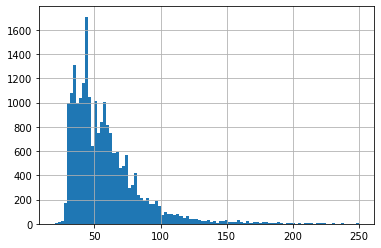

In [59]:
data['total_area'].hist(bins=100);

Максимальное количество квартир представлены в стандартной массовой застройке площадью от 30 до 100 кв.м.

<AxesSubplot:>

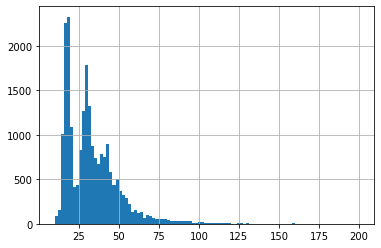

In [60]:
data['living_area'].hist(bins=100)

Большая часть квартир имеет стандартные жилые площди от 12 кв.м (скорее всего студии) до 50 кв.м. (стандартные 3х комнатные)

<AxesSubplot:>

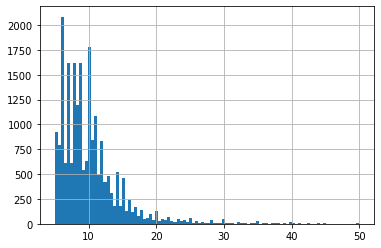

In [61]:
data['kitchen_area'].hist(bins=100)

Большая часть квартир имеет стандартные  площди кухни от 5 кв.м  до 15 кв.м. 

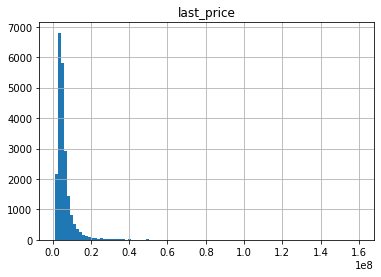

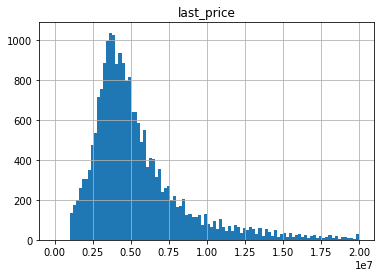

In [62]:
data.hist('last_price', bins=100);
data.hist('last_price', bins=100, range=(0,2e+07));

Максимльное количество квартир продано за 3 млн.

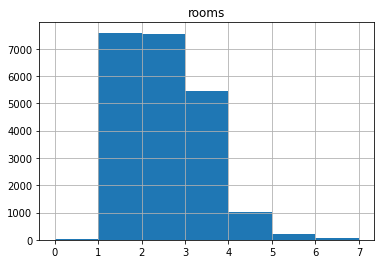

In [63]:
data.hist('rooms', bins=data['rooms'].max());

Большинство квартир имеет стандартные планировки 1,2,3 комнаты. Максимальное количество комнат 7

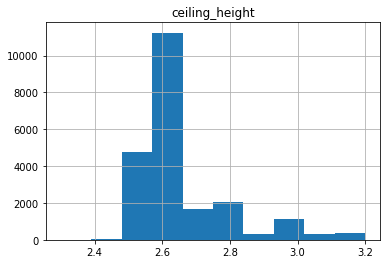

In [64]:
data.hist('ceiling_height', bins=10);

Большинство квартир имеет стандартные высоты потолков - 2,5 - 2,7 м. Встречаются небольшие исключения.

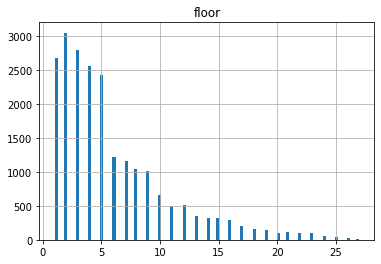

In [65]:
data.hist('floor', bins=100);

Максимальное количество продаж квартир на этажах до 5. Что может объясняться старым массовым жилым фондом высотой до 5 этажей.

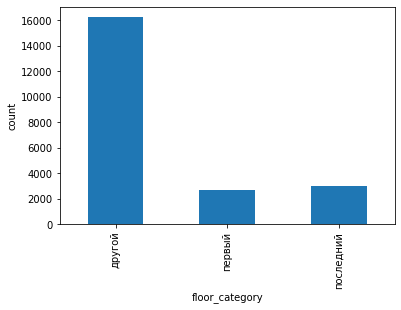

In [66]:
data.groupby(by='floor_category')['floor_category'].count().plot(kind='bar', ylabel = 'count');

Минимальное количество квартир на первом этаже. 

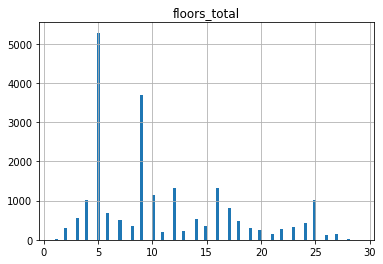

In [67]:
data.hist('floors_total', bins=100);

Максимальное количество домов в 5 и 9 этажей. Что может объясняться старым массовым жилым фондом высотой до 5 и 9 этажей.

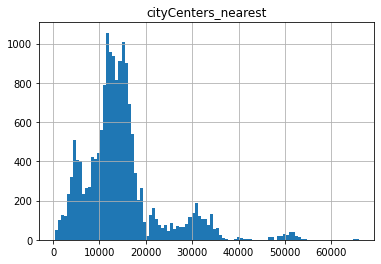

In [68]:
data.hist('cityCenters_nearest', bins=100);

Максимальное количество продаж фиксируется в спальных районах.

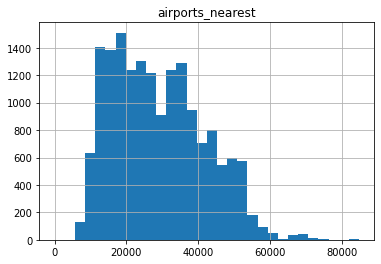

In [69]:
data.hist('airports_nearest', bins=30);

В среднем расстояние до аэропорта составляет 20 км до 40 км. 

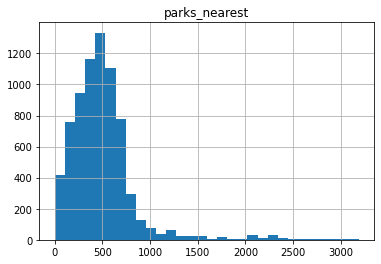

In [70]:
data.hist('parks_nearest', bins=30);

В основном квартиры находятся в шаговой доступности от парковой зоны до 1 км.

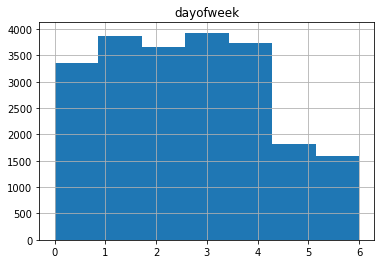

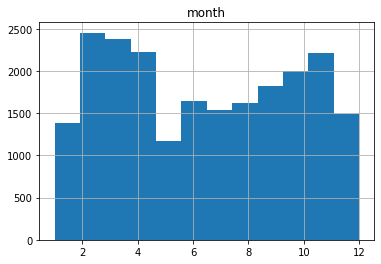

In [71]:
data.hist('dayofweek', bins=7);

data.hist('month', bins=12);

Среднее время продажи квартиры в днях: 170
Медианное время продажи квартиры в днях: 93


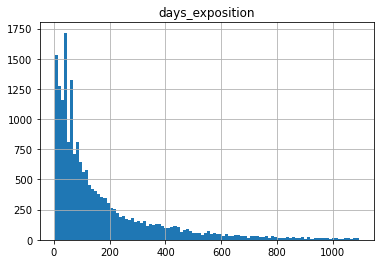

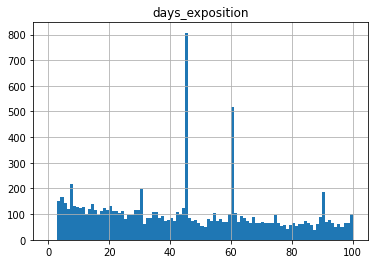

In [72]:
data.hist('days_exposition', bins=100);
data.hist('days_exposition', bins=100, range = (0,100));
print(f'Среднее время продажи квартиры в днях:',int(data['days_exposition'].mean()))
print('Медианное время продажи квартиры в днях:',int(data['days_exposition'].median()))

,total_area,last_price
total_area,1.0000,0.7193
last_price,0.7193,1.0000


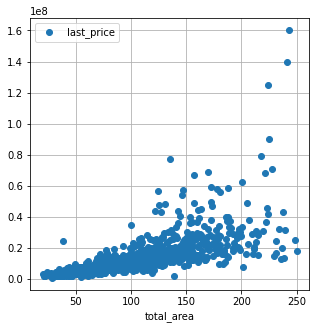

In [73]:
data.pivot_table(index='total_area', values='last_price').plot(grid=True, style='o', figsize=(5, 5))
#data.pivot_table(index='floor', values=['total_area', 'last_price']).corr(),'\n'
columns=['total_area', 'last_price']
subset=data[columns]
subset.corr()

In [74]:
# check
data[['total_area', 'last_price']].corr()

,total_area,last_price
total_area,1.0000,0.7193
last_price,0.7193,1.0000


,living_area,last_price
living_area,1.000000,0.628347
last_price,0.628347,1.000000


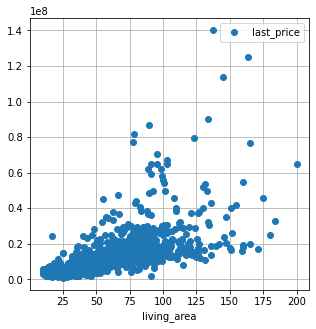

In [75]:
data.pivot_table(index='living_area', values='last_price').plot(grid=True, style='o', figsize=(5, 5))
#data.pivot_table(index='floor', values=['living_area', 'last_price']).corr(),'\n'
columns=['living_area', 'last_price']
subset=data[columns]
subset.corr()

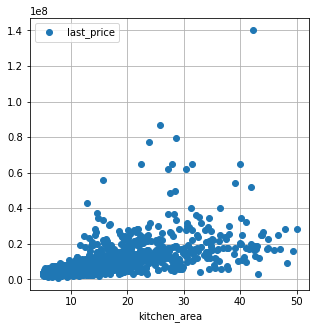

In [76]:
data.pivot_table(index='kitchen_area', values='last_price').plot(grid=True, style='o', figsize=(5, 5))
#data.pivot_table(index='floor', values=['kitchen_area', 'last_price']).corr(),'\n'
columns=['kitchen_area', 'last_price']
subset=data[columns]

,rooms,last_price
rooms,1.000000,0.421818
last_price,0.421818,1.000000


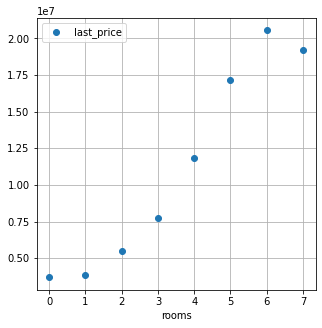

In [77]:
data.pivot_table(index='rooms', values='last_price').plot(grid=True, style='o', figsize=(5, 5))
#data.pivot_table(index='floor', values=['rooms', 'last_price']).corr(),'\n'
columns=['rooms', 'last_price']
subset=data[columns]
subset.corr()

,last_price
last_price,1.0


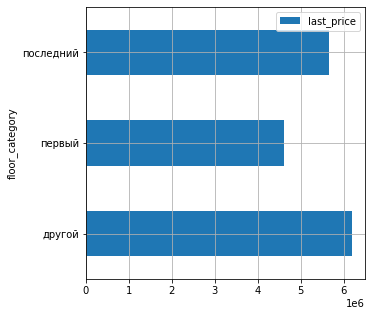

In [78]:
data.pivot_table(index='floor_category', values='last_price').plot(kind='barh', grid=True, style='o', figsize=(5, 5));
#data.pivot_table(index='floor', values=['floor_category', 'last_price']).corr(),'\n'
columns=['floor_category', 'last_price']
subset=data[columns]
subset.corr()

,last_price
last_price,1.0


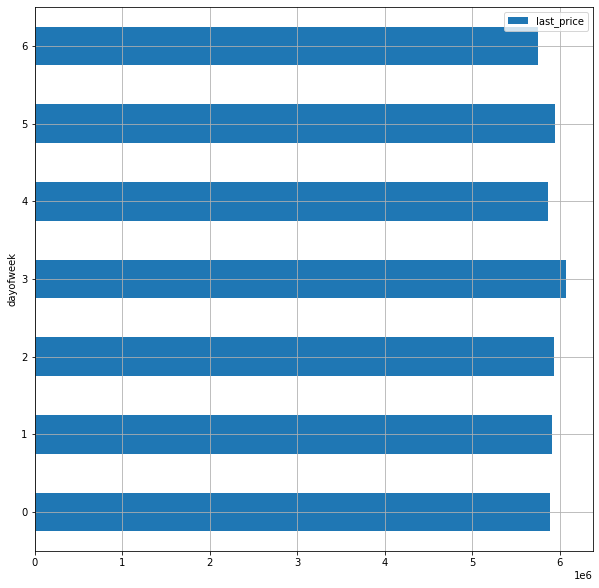

In [79]:
data.pivot_table(index=['dayofweek'], values='last_price').plot(kind='barh', grid=True, style='o', figsize=(10, 10));
#data.pivot_table(index='floor', values=['dayofweek', 'month', 'year', 'last_price']).corr(),'\n'
subset.corr()

In [80]:
columns=['dayofweek', 'last_price']
subset=data[columns]

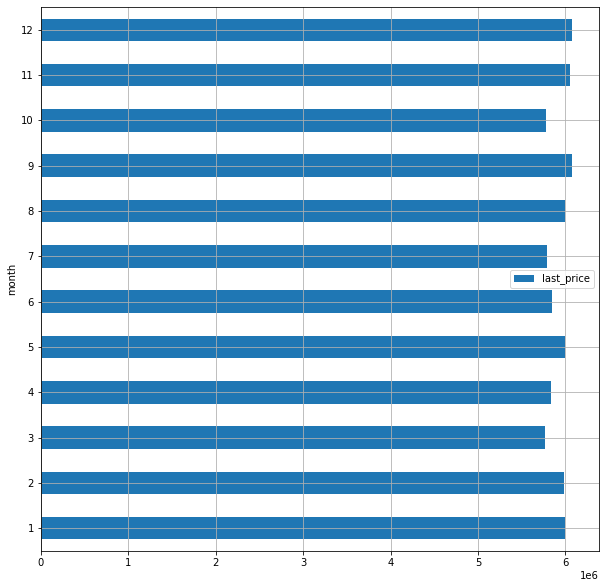

In [81]:
data.pivot_table(index=['month'], values='last_price').plot(kind='barh', grid=True, style='o', figsize=(10, 10));

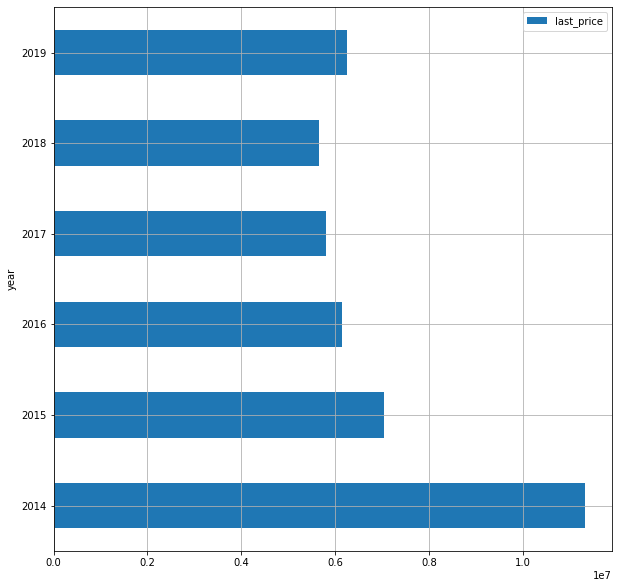

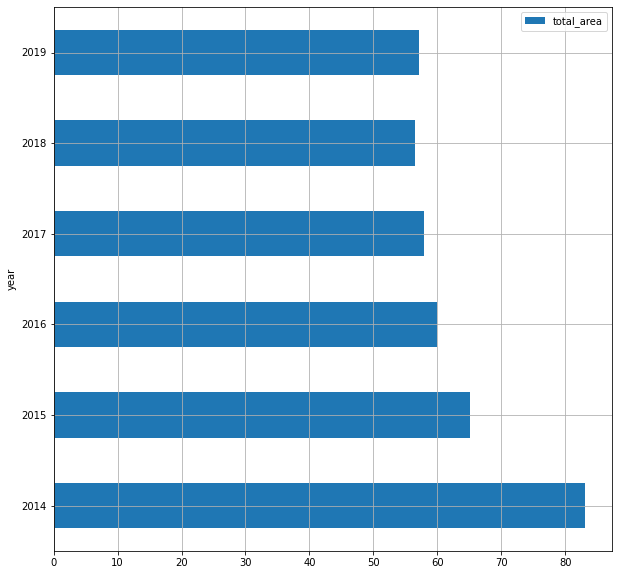

In [82]:
data.pivot_table(index=['year'], values='last_price').plot(kind='barh', grid=True, style='o', figsize=(10, 10));
data.pivot_table(index=['year'], values='total_area').plot(kind='barh', grid=True, style='o', figsize=(10, 10));


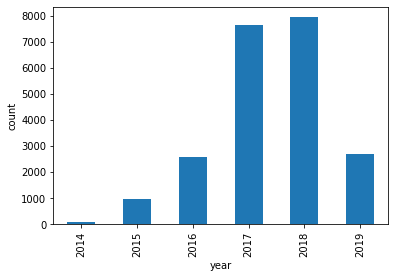

In [83]:
data.groupby(by='year')['last_price'].count().plot(kind='bar', ylabel = 'count');

Исходя из полученных данных можно сделать вывод, что цена квартиры на прямую зависит от площади картиры, количества комнат и этаж располажения квартир. На стоимость квартир не влияет день и месяц публикации объявления. Так же можно сделать выводы что с 2014 по 2018 год стоимость квартир снижалась и в 2019 году начала подниматься. Стомость снижалась в 2017 и 2018 годах из-за большого количества предложений.

                     price_sqr_m
locality_name                   
Всеволожск          68668.540879
Выборг              58245.190455
Гатчина             69059.609003
Колпино             75229.566500
Кудрово             94742.080098
Мурино              84904.602486
Пушкин             102685.350326
Санкт-Петербург    112009.111311
поселок Парголово   90197.547284
поселок Шушары      77980.635341


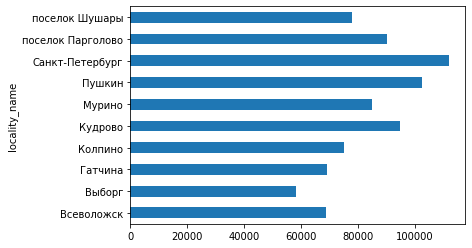

In [84]:
city_ten = data['locality_name'].value_counts().head(10)
city_sm_price = data.query('locality_name in (@city_ten.index)').pivot_table(values='price_sqr_m', index='locality_name')
print(city_sm_price.head(10))
city_sm_price = city_sm_price.astype(int)
#city_sm_price.sort_values('price_sqr_m', ascending=False).plot(grid=True, style='o', figsize=(10,10));
city_sm_price['price_sqr_m'].plot(kind='barh');

406513.3922916714


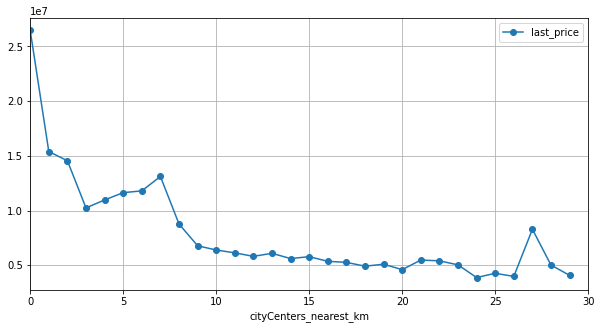

In [85]:
center_km=data.query('locality_name == "Санкт-Петербург"').pivot_table(index='cityCenters_nearest_km', values='last_price').plot(grid=True, style='o-', xlim=(0,30), figsize=(10, 5))
cost_km=data['last_price'].mean()/data['cityCenters_nearest_km'].mean()
print(cost_km)

Данный расчет производился для собственного понятия покажет ли что-то эта цифра. в итоге нигде не исполльзовалась. 

In [86]:
data.query('cityCenters_nearest_km == 27' and 'locality_name == "Санкт-Петербур"')['cityCenters_nearest_km'].count()


0

In [87]:
data.query('cityCenters_nearest_km == 27' and 'locality_name == "Санкт-Петербур"').sort_values(by='last_price', ascending=False).head(25)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_sqr_m,dayofweek,month,year,floor_category,cityCenters_nearest_km


In [88]:
# check
data.query('cityCenters_nearest_km == 27 and locality_name == "Санкт-Петербург"').sort_values(by='last_price', ascending=False).head(25)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_sqr_m,dayofweek,month,year,floor_category,cityCenters_nearest_km
748,13,14350000,74.0,2017-11-28,2,3.13,5,30.0,3,NaN,...,1496.0,0.0,NaN,128.0,193918.918919,1,11,2017,другой,27
5961,6,2250000,32.0,2018-02-27,1,2.65,2,16.5,2,NaN,...,NaN,0.0,NaN,178.0,70312.500000,1,2,2018,последний,27


In [89]:
data.groupby(['cityCenters_nearest_km', 'locality_name']).agg({'last_price':'max', 'total_area':'max'}).loc[26:28].head(27)

last_price  total_area
cityCenters_nearest_km locality_name                                  
26                     Пушкин                     26500000       157.3
                       Санкт-Петербург             7900000       100.0
                       поселок Левашово            4200000        43.3
                       поселок Лисий Нос           7305000        43.3
                       поселок Песочный            2900000        30.1
27                     Красное Село                3000000        37.0
                       Пушкин                     29500000       190.0
                       Санкт-Петербург            14350000        74.0
                       поселок Александровская     3750000        59.0
                       поселок Металлострой        5350000        75.0
28                     Красное Село               21000000       215.0
                       Пушкин                     16500000       151.0
                       Санкт-Петербург             7600000       111.0
                       поселок Александровская    13700000       178.0
                       поселок Лисий Нос           2350000        40.0
                       поселок Металлострой        5500000        94.0
                       поселок Песочный            3200000        49.0
                       поселок Усть-Ижора          3900000        57.0
                       поселок Шушары              2550000        41.0

In [90]:
rating.isna()

,cityCenters_nearest_km
locality_name,
Зеленогорск,54.909091
Колпино,32.018072
Красное Село,29.976608
Кронштадт,49.059524
Ломоносов,50.614173
Мурино,22.0
Павловск,33.25
Петергоф,35.523077
Пушкин,28.736232


In [91]:
data.groupby(['cityCenters_nearest_km', 'floor_category']).agg({'floor_category':'count'}).loc[3:5].head(60)
                                                               

floor_category
cityCenters_nearest_km floor_category                
3                      другой                     144
                       первый                      42
                       последний                   61
4                      другой                     389
                       первый                      67
                       последний                   87
5                      другой                     543
                       первый                      63
                       последний                  105

In [92]:
columns=['cityCenters_nearest_km', 'last_price']
subset=data[columns]
subset.corr()

,cityCenters_nearest_km,last_price
cityCenters_nearest_km,1.000000,-0.288141
last_price,-0.288141,1.000000


На расстоянии 27 км, от центра выставлена квартира с ценником в 2 раза больше чем на 26 и 28 км. Возможно данная квартира находится в г. Пушкин, т.к. ценники за квадрат примерно равны. 

На 3м км большинство квартир продаются на первых и последних этажах, что оказывает влияние на стоимость. 

### Общий вывод

Большая часть квартир продается за 93 дня. Так же есть пики продаж квартир за 45 и 60 дней, 
что является хорошим показателем.
На стоимость больше влияет площадь квартиры, этаж квартиры и район расположения квартиры, чем ближе к центру, 
тем дороже квартиры. Есть провал на 3 км. 71% это первые и последние этажи. Вероятно, это старая застройка. Возможно остатки 2х этажных старых домов. 
Стоимость квадратного метра в топ-10 населённых пунктов

Дороже всего квадратный метр в Санкт-Петербурге - 112009.11
Дешевле всего квадратный метр в Выборге - 58245.19
Далее 8 км от центра стоимость квартир примерно одинаковые.
Повышение стоимости начало фиксироваться в 2019 году, т.к. снизилось количество предложений.
Большая активность начала продажи фиксируется в феврале-апреле. 

In [93]:
# check
import seaborn as sns
import matplotlib.pyplot as plt

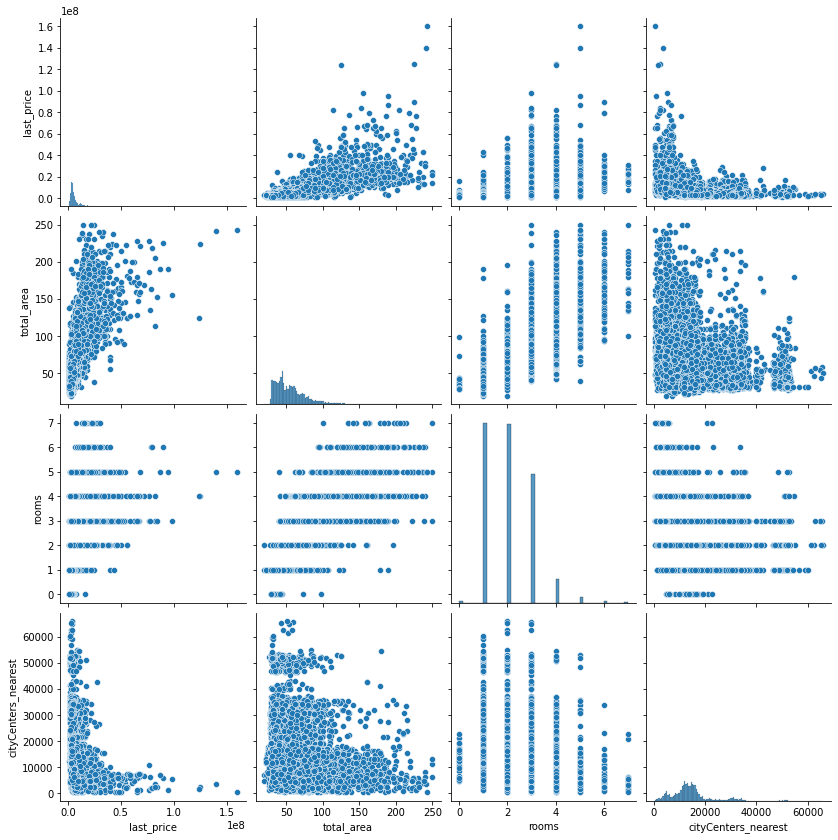

In [94]:
# check
sns.pairplot(data[['last_price', 'total_area', 'rooms', 'cityCenters_nearest']])
plt.gcf().set_size_inches(12,12);


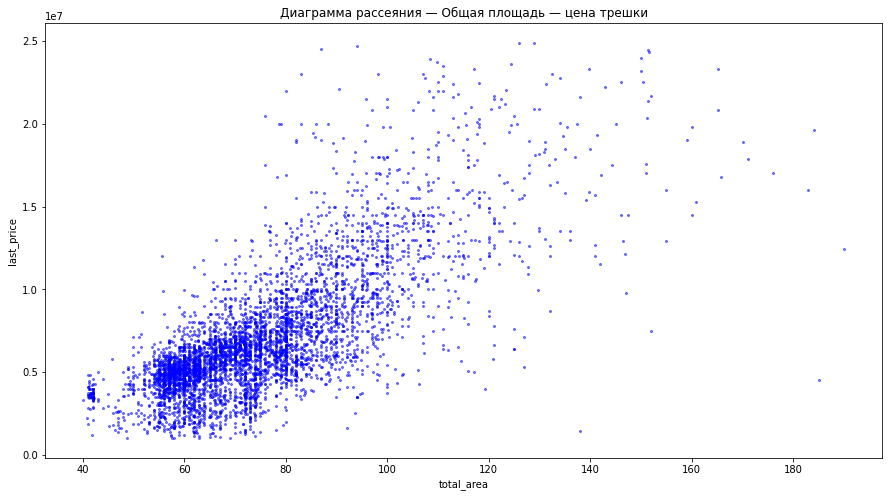

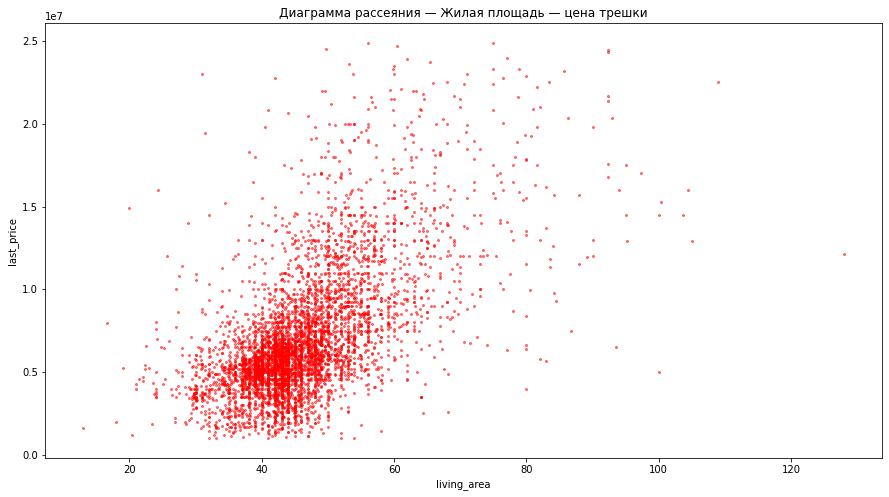

In [95]:
# check
data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
        y='last_price' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Общая площадь — цена трешки')


data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter', 
        y='last_price' , x='living_area', alpha=0.5, figsize=(15,8), c = 'r', s = 4)
plt.title('Диаграмма рассеяния — Жилая площадь — цена трешки');

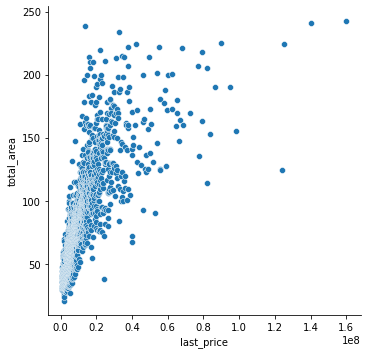

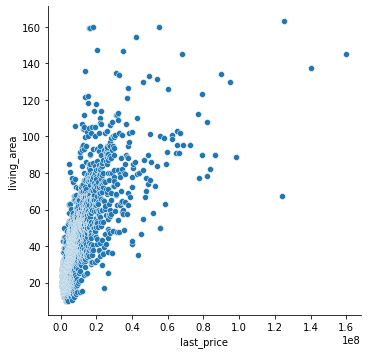

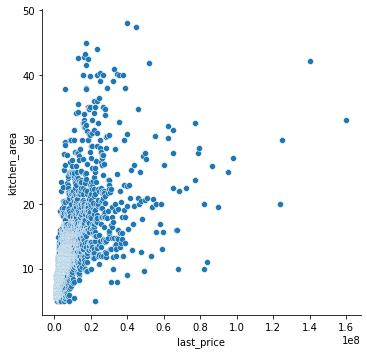

In [96]:
# check
price_pivot_area = data.pivot_table(index='last_price', values=([
    'total_area', 'living_area', 'kitchen_area']), aggfunc='median')
price_pivot_area = price_pivot_area.reset_index()
# Посмотрим на диаграммы рассеяния для столбцов 'total_area', 'living_area', 'kitchen_area'.
for row in ['total_area', 'living_area', 'kitchen_area']:
    sns.relplot(data=price_pivot_area, x='last_price', y=row, kind='scatter')

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.